# Ingeniería de Características

Se efectúa un análisis de las características y cálculos hechos en `features.py`

- Análisis de valores nulos y tratamiento (imputación de `LTV_180`),
- Transformaciones logarítmicas,
- Generación de variables temporales,
- Encoding categórico (para modelos lineales y LightGBM),
- Análisis visual y estadístico.

## Librerías y Datos

Para este cuaderno, las librerías son las siguienetes, y dado que es un nuevo csv a partir de los datos intermedios ubicados en `data/interim`, se los importa desde `data/processed`

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import os

# Configuración de estilos
plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)

# Cargar el dataset de features
features = pd.read_csv('../data/processed/features.csv')

# Mostrar primeras filas
features.head()


,uid,num_sessions,avg_duration,max_duration,first_session,last_session,LTV_180,CAC_source_30,marketing_channel
0,"11,863,502,262,781.00",1,6.00,6.00,2018-03-01 17:27:00,2018-03-01 17:27:00,NaN,427.32,3
1,"49,537,067,089,222.00",1,2.00,2.00,2018-02-06 15:55:00,2018-02-06 15:55:00,NaN,151.37,2
2,"297,729,379,853,735.00",1,1.00,1.00,2017-06-07 18:47:00,2017-06-07 18:47:00,NaN,243.32,3
3,"313,578,113,262,317.00",3,11.00,18.00,2017-09-18 22:49:00,2018-03-11 17:23:00,0.55,145.13,2
4,"325,320,750,514,679.00",2,5.00,9.00,2017-09-30 14:29:00,2018-02-26 12:33:00,NaN,186.05,5


## Revisión General

Un primer vistazo a `features.csv` en busca de valores ausentes, tipos de datos no correctos, y valores atípicos

In [15]:
print("Información del dataset:")
print(features.info())

print("\nDescripción estadística general:")
print(features.describe())

print("\nProporción de valores nulos por columna:")
print(features.isna().mean().sort_values(ascending=False))

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228169 entries, 0 to 228168
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   uid                228169 non-null  float64
 1   num_sessions       228169 non-null  int64  
 2   avg_duration       228169 non-null  float64
 3   max_duration       228169 non-null  float64
 4   first_session      228169 non-null  object 
 5   last_session       228169 non-null  object 
 6   LTV_180            35651 non-null   float64
 7   CAC_source_30      226709 non-null  float64
 8   marketing_channel  228169 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.7+ MB
None

Descripción estadística general:
                                uid  num_sessions  avg_duration  max_duration  \
count                    228,169.00    228,169.00    228,169.00    228,169.00   
mean   9,219,372,553,623,351,296.00          1.45          8.7

## Distribuciones

Se observan las distribuciones de las variables numéricas creadas

Resumen estadístico de las variables numéricas:
       num_sessions  avg_duration  max_duration   LTV_180  CAC_source_30
count    228,169.00    228,169.00    228,169.00 35,651.00     226,709.00
mean           1.45          8.79         11.22      5.56         230.71
std            2.61         11.23         16.43     22.42         153.51
min            1.00          0.00          0.00      0.12           6.34
25%            1.00          2.00          2.00      1.47         133.78
50%            1.00          5.00          5.00      3.00         187.99
75%            1.00         12.00         15.00      5.55         271.50
max          259.00        349.00        711.00  2,711.31         822.30

Distribuciones (gráficas):


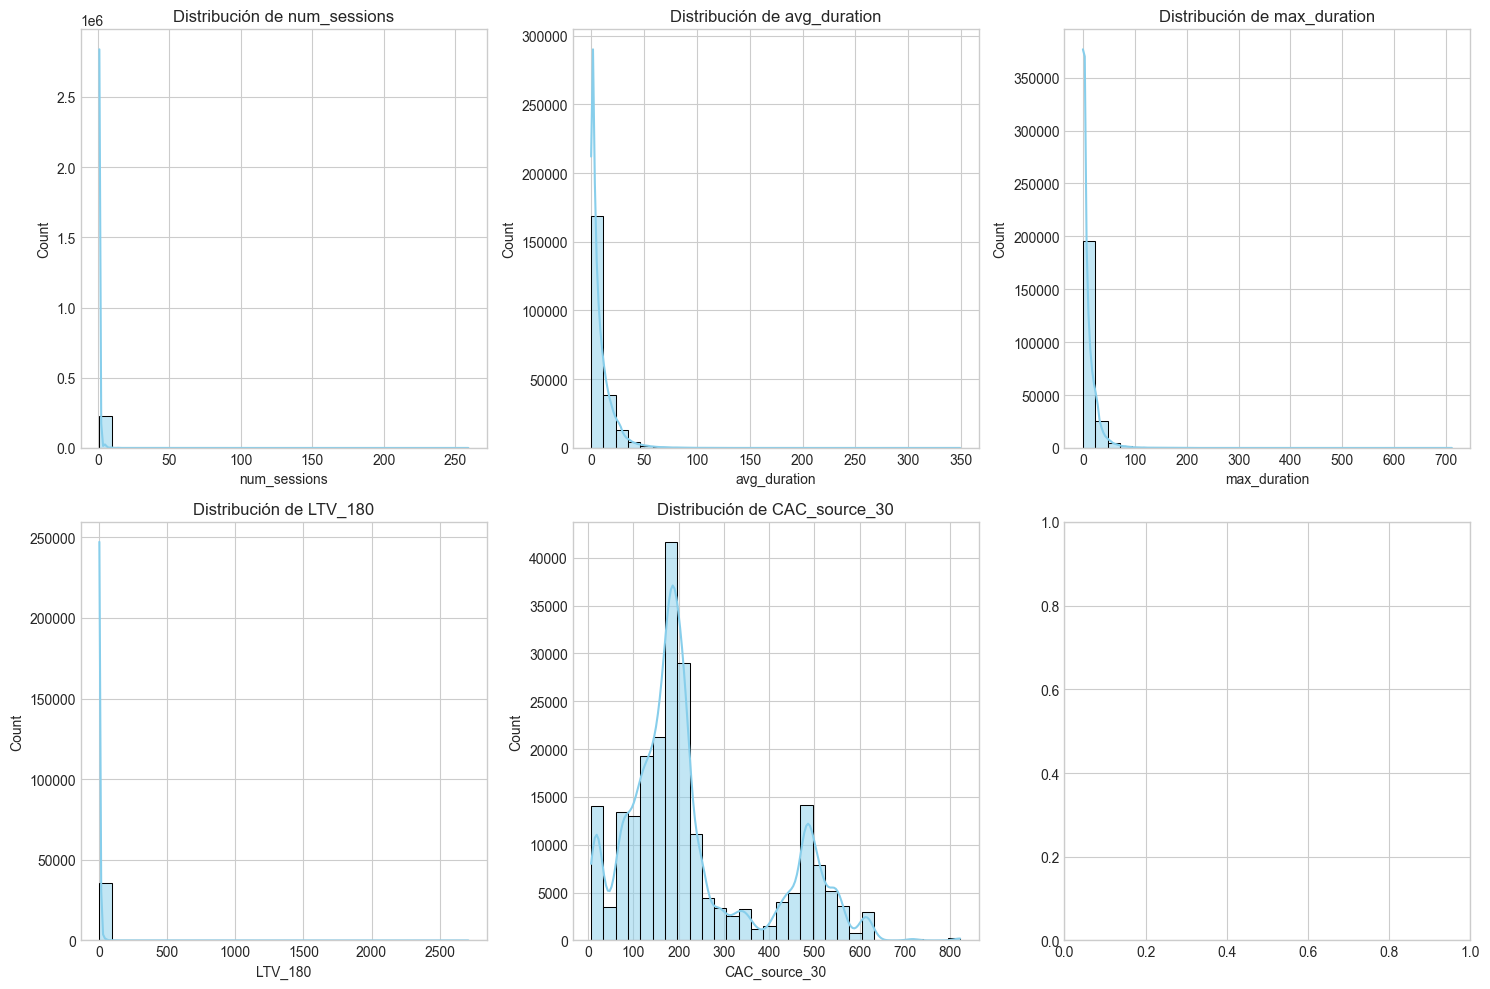

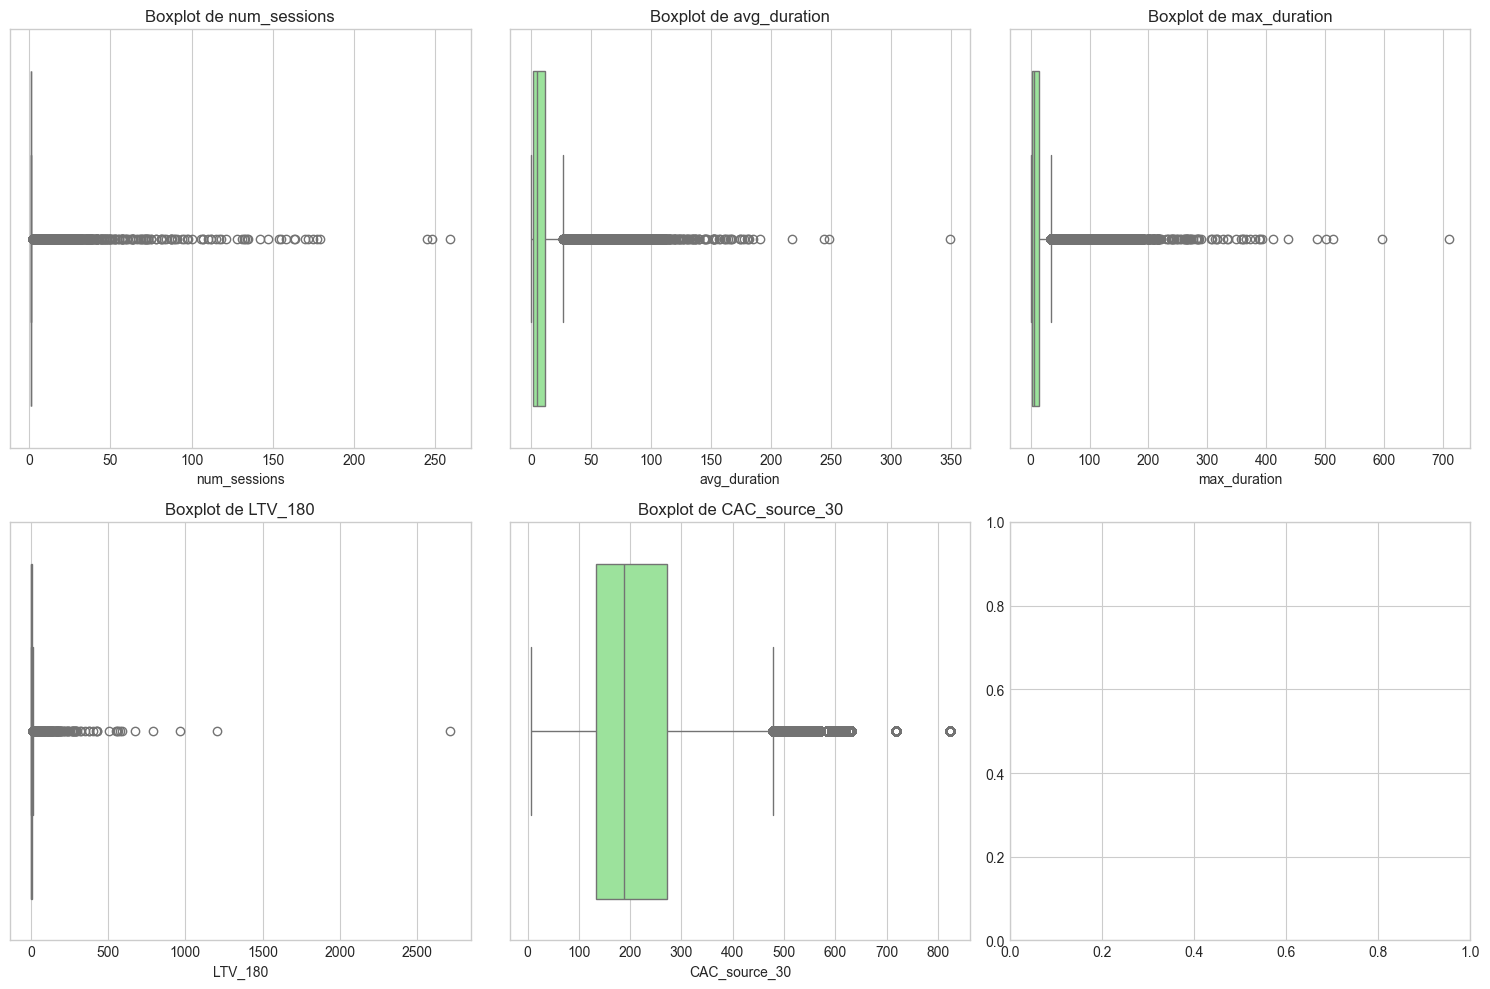

In [16]:
numeric_cols = ['num_sessions', 'avg_duration', 'max_duration', 'LTV_180', 'CAC_source_30']

print("Resumen estadístico de las variables numéricas:")
print(features[numeric_cols].describe())

print("\nDistribuciones (gráficas):")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(features[col].dropna(), kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribución de {col}')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=features[col].dropna(), ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()


## Correlaciones

Correlaciones entre variables numéricas

Matriz de correlación entre variables numéricas:
               num_sessions  avg_duration  max_duration  LTV_180  \
num_sessions           1.00          0.06          0.37     0.42   
avg_duration           0.06          1.00          0.84     0.03   
max_duration           0.37          0.84          1.00     0.19   
LTV_180                0.42          0.03          0.19     1.00   
CAC_source_30         -0.04          0.01         -0.01    -0.03   

               CAC_source_30  
num_sessions           -0.04  
avg_duration            0.01  
max_duration           -0.01  
LTV_180                -0.03  
CAC_source_30           1.00  


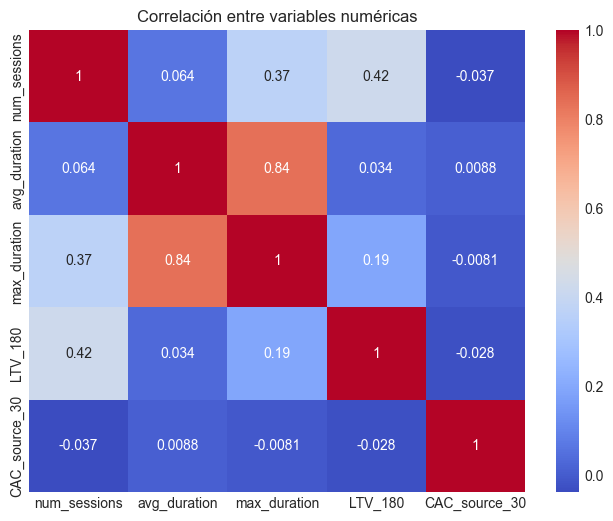

In [17]:
corr_matrix = features[numeric_cols].corr()

print("Matriz de correlación entre variables numéricas:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()


## Análisis `LTV_180`

Comportamiento del Target es central para cualquier tarea de predicción

Descripción estadística de LTV_180:
count   35,651.00
mean         5.56
std         22.42
min          0.12
25%          1.47
50%          3.00
75%          5.55
max      2,711.31
Name: LTV_180, dtype: float64


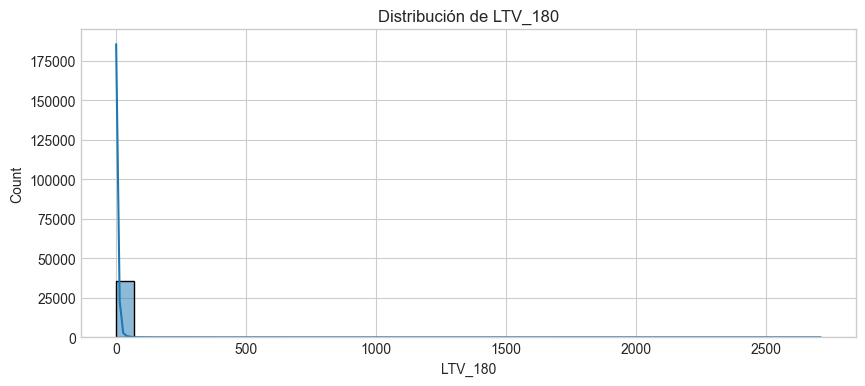


Boxplot de LTV_180 según número de sesiones:


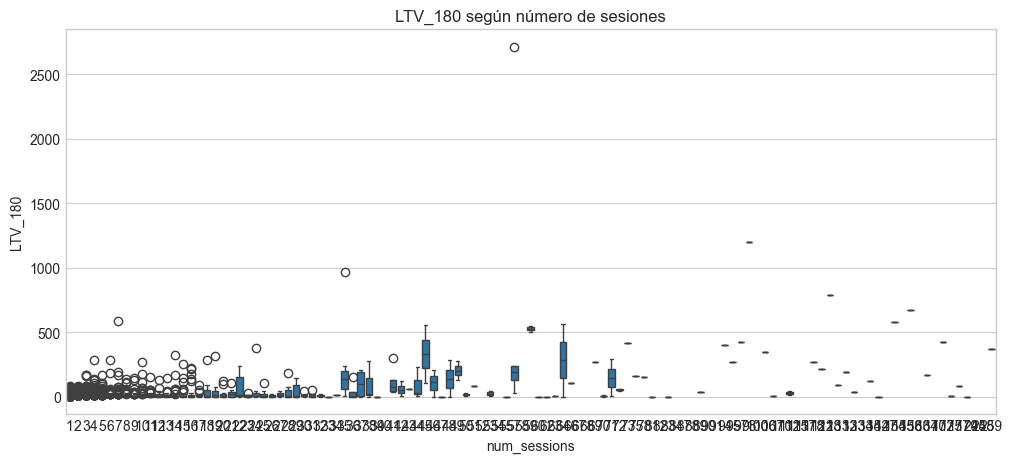

In [18]:
print("Descripción estadística de LTV_180:")
print(features['LTV_180'].describe())

plt.figure(figsize=(10, 4))
sns.histplot(features['LTV_180'].dropna(), bins=40, kde=True)
plt.title("Distribución de LTV_180")
plt.show()

print("\nBoxplot de LTV_180 según número de sesiones:")
plt.figure(figsize=(12, 5))
sns.boxplot(x='num_sessions', y='LTV_180', data=features)
plt.title("LTV_180 según número de sesiones")
plt.show()


## Imputación de LTV

- Crea una variable booleana is_ltv_imputed para saber luego cuáles valores fueron imputados.

- Usa un modelo auxiliar (RandomForestRegressor) para predecir los valores faltantes de LTV_180 con base en otras variables numéricas.

- Entrena el modelo con los registros que sí tienen LTV, luego predice para los que no.

- Asigna los valores imputados a una nueva columna LTV_180_imputed.

Esto se hace debido a que LTV ha resultado ser una variable derivada con numerosos valores nulos, y se la debe manejar. Es inviable borrar los valores nulos

In [19]:
# Generamos bandera para imputación
features['is_ltv_imputed'] = features['LTV_180'].isna().astype(int)

# Seleccionamos features sin NaN para entrenar el modelo auxiliar
train_aux = features.dropna(subset=['LTV_180'])
X_train_aux = train_aux[['num_sessions', 'avg_duration', 'max_duration', 'CAC_source_30']].fillna(0)
y_train_aux = train_aux['LTV_180']

# Entrenamiento del modelo auxiliar
rf_aux = RandomForestRegressor(n_estimators=50, random_state=42)
rf_aux.fit(X_train_aux, y_train_aux)

# Predicción de valores faltantes
to_impute = features[features['LTV_180'].isna()]
X_impute = to_impute[['num_sessions', 'avg_duration', 'max_duration', 'CAC_source_30']].fillna(0)
imputed_values = rf_aux.predict(X_impute)

# Asignar valores imputados a nueva columna
features['LTV_180_imputed'] = features['LTV_180']
features.loc[features['LTV_180'].isna(), 'LTV_180_imputed'] = imputed_values

# Diagnóstico en consola
print(f"Imputación completada.")
print(f"Total de registros imputados: {features['is_ltv_imputed'].sum()}")
print(f"Estadísticas después de imputar:")
print(features['LTV_180_imputed'].describe())


Imputación completada.
Total de registros imputados: 192518
Estadísticas después de imputar:
count   228,169.00
mean          4.57
std          10.35
min           0.12
25%           2.38
50%           3.56
75%           5.23
max       2,711.31
Name: LTV_180_imputed, dtype: float64


## Cálculo de AOV

Valor promedio de órdenes:

In [20]:
# Calcular AOV: LTV_180_imputed dividido por num_sessions (suponiendo que son equivalentes a orders_count)
features['AOV'] = features.apply(lambda row: row['LTV_180_imputed'] / row['num_sessions'] if row['num_sessions'] > 0 else 0, axis=1)

# Diagnóstico en consola
print("Cálculo de AOV completado.")
print(features[['LTV_180_imputed', 'num_sessions', 'AOV']].head())

Cálculo de AOV completado.
   LTV_180_imputed  num_sessions  AOV
0             3.61             1 3.61
1             2.42             1 2.42
2             2.66             1 2.66
3             0.55             3 0.18
4             4.56             2 2.28


## Transformación Logarítmica de `LTV`

`LTV` tiene un sesgo muy fuerte, por lo que se le realiza una transformación logarítmica 

- Aplica log1p() (logaritmo natural de 1 + x) a LTV_180_imputed para reducir el sesgo de cola larga.

- Esto es una buena práctica en problemas donde los valores pueden variar en órdenes de magnitud.

Transformación logarítmica completada.
Estadísticas de 'log_LTV_180':
count   228,169.00
mean          1.55
std           0.51
min           0.11
25%           1.22
50%           1.52
75%           1.83
max           7.91
Name: log_LTV_180, dtype: float64


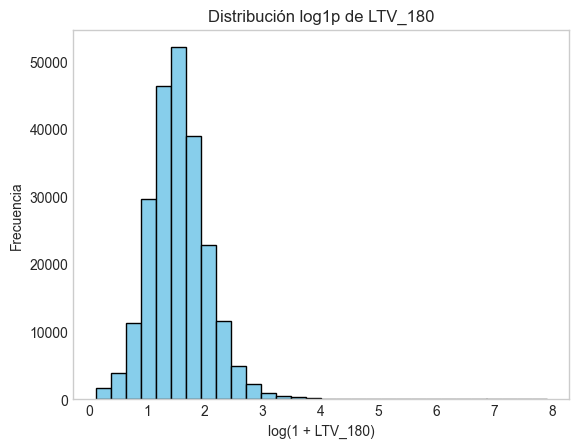

In [21]:
# Aplicamos log1p para suavizar el sesgo
features['log_LTV_180'] = np.log1p(features['LTV_180_imputed'])

# Diagnóstico en consola
print("Transformación logarítmica completada.")
print("Estadísticas de 'log_LTV_180':")
print(features['log_LTV_180'].describe())

# Visualización
features['log_LTV_180'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución log1p de LTV_180")
plt.xlabel("log(1 + LTV_180)")
plt.ylabel("Frecuencia")
plt.grid(False)
plt.show()

## Visualización 

Se da un nuevo vistazo a `LTV_180`tanto antes como después de la transformación logarítmica

Comparación de estadísticas entre LTV_180_imputed y log_LTV_180

LTV_180_imputed:
count   228,169.00
mean          4.57
std          10.35
min           0.12
25%           2.38
50%           3.56
75%           5.23
max       2,711.31
Name: LTV_180_imputed, dtype: float64

log_LTV_180:
count   228,169.00
mean          1.55
std           0.51
min           0.11
25%           1.22
50%           1.52
75%           1.83
max           7.91
Name: log_LTV_180, dtype: float64


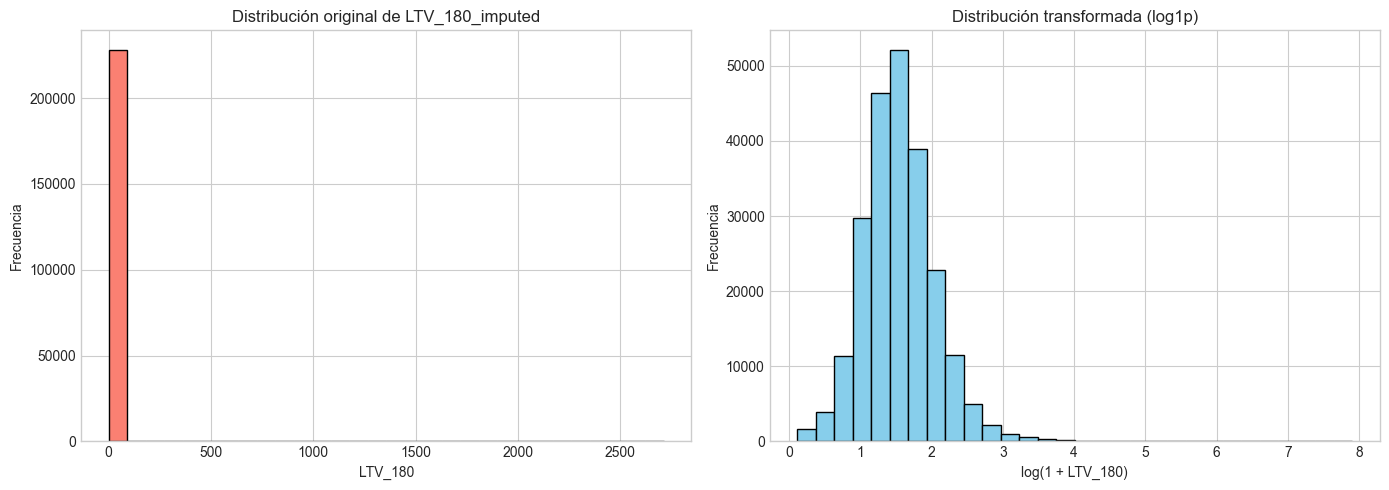


Comparación de distribución entre imputados y no imputados:


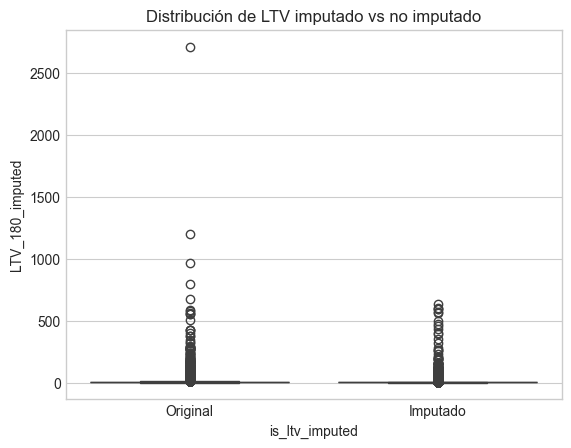

In [22]:
# Estadísticas comparativas en consola
print("Comparación de estadísticas entre LTV_180_imputed y log_LTV_180\n")
print("LTV_180_imputed:")
print(features['LTV_180_imputed'].describe())
print("\nlog_LTV_180:")
print(features['log_LTV_180'].describe())

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma original
axes[0].hist(features['LTV_180_imputed'], bins=30, color='salmon', edgecolor='black')
axes[0].set_title("Distribución original de LTV_180_imputed")
axes[0].set_xlabel("LTV_180")
axes[0].set_ylabel("Frecuencia")

# Histograma transformado
axes[1].hist(features['log_LTV_180'], bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("Distribución transformada (log1p)")
axes[1].set_xlabel("log(1 + LTV_180)")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

print("\nComparación de distribución entre imputados y no imputados:")
sns.boxplot(x='is_ltv_imputed', y='LTV_180_imputed', data=features)
plt.title("Distribución de LTV imputado vs no imputado")
plt.xticks([0, 1], ['Original', 'Imputado'])
plt.show()



## Variables Temporales Derivadas

- Convierte las fechas a formato datetime.

- Calcula tres variables clave:

- recency_days: días desde la última sesión del cliente.

- lifetime_days: duración de la relación cliente-empresa.

- first_session_month y last_session_weekday: mes de primera sesión y día de la semana de última sesión, útiles para patrones temporales.

In [23]:
features['first_session'] = pd.to_datetime(features['first_session'])
features['last_session'] = pd.to_datetime(features['last_session'])

# Derivadas: recencia, tiempo de vida, antigüedad
features['recency_days'] = (features['last_session'].max() - features['last_session']).dt.days
features['lifetime_days'] = (features['last_session'] - features['first_session']).dt.days
features['first_session_month'] = features['first_session'].dt.month
features['last_session_weekday'] = features['last_session'].dt.weekday

print("Variables temporales generadas:")
print(features[['recency_days', 'lifetime_days', 'first_session_month', 'last_session_weekday']].describe())


Variables temporales generadas:
       recency_days  lifetime_days  first_session_month  last_session_weekday
count    228,169.00     228,169.00           228,169.00            228,169.00
mean         156.38          16.06                 6.72                  2.84
std           93.06          49.81                 3.79                  1.95
min            0.00           0.00                 1.00                  0.00
25%           83.00           0.00                 3.00                  1.00
50%          153.00           0.00                 7.00                  3.00
75%          221.00           0.00                10.00                  4.00
max          364.00         364.00                12.00                  6.00


## Encoding Categórico

In [24]:
# OneHotEncoding para modelos lineales
features_encoded = pd.get_dummies(features.copy(), columns=['marketing_channel'], prefix='channel')

print("Variables después del encoding OneHot:")
print(features_encoded.filter(like='channel_').head())


Variables después del encoding OneHot:
   channel_1  channel_2  channel_3  channel_4  channel_5  channel_6  \
0      False      False       True      False      False      False   
1      False       True      False      False      False      False   
2      False      False       True      False      False      False   
3      False       True      False      False      False      False   
4      False      False      False      False       True      False   

   channel_7  channel_9  channel_10  
0      False      False       False  
1      False      False       False  
2      False      False       False  
3      False      False       False  
4      False      False       False  


## Analizado a `marketing_channel`

¿Qué tan importante es el Canal de Marketing?

Cantidad de usuarios por canal de marketing:
marketing_channel
4     71958
3     60386
5     48591
2     20427
1     12974
9      7155
10     6644
7        30
6         4
Name: count, dtype: int64


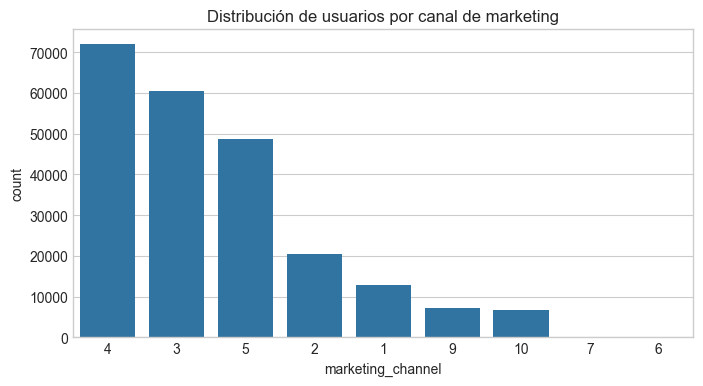


Boxplot de LTV_180 por canal de marketing:


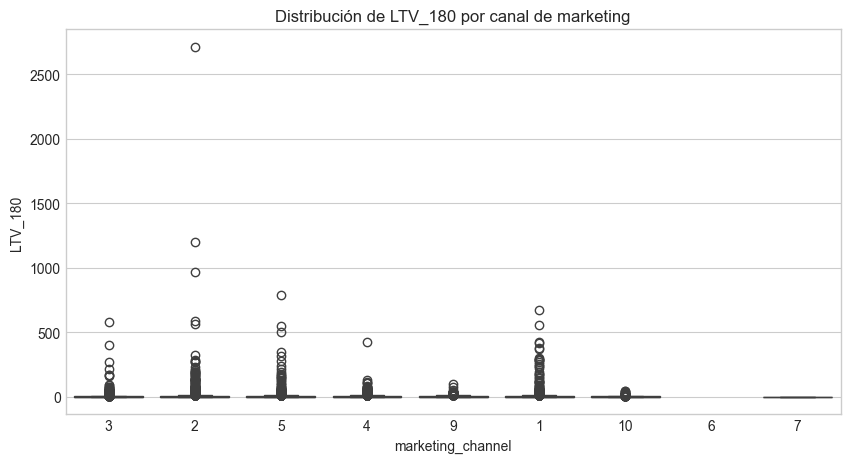

In [25]:
features['marketing_channel'] = features['marketing_channel'].astype(str)

print("Cantidad de usuarios por canal de marketing:")
print(features['marketing_channel'].value_counts())

plt.figure(figsize=(8, 4))
sns.countplot(x='marketing_channel', data=features, order=features['marketing_channel'].value_counts().index)
plt.title("Distribución de usuarios por canal de marketing")
plt.show()

print("\nBoxplot de LTV_180 por canal de marketing:")
plt.figure(figsize=(10, 5))
sns.boxplot(x='marketing_channel', y='LTV_180', data=features)
plt.title("Distribución de LTV_180 por canal de marketing")
plt.show()


## Guardar Dataset Final 

Todas las figuras generadas para esta sección se guardan en `reports/figures/final`. De la misma forma, el dataset destinado al entrenamiento de modelos, `final_dataset.csv` dentro de `data/final/`

Figura guardada: ../reports/figures/engineered\distribuciones.png
Figura guardada: ../reports/figures/engineered\boxplots.png
Figura guardada: ../reports/figures/engineered\correlacion.png
Figura guardada: ../reports/figures/engineered\distribucion_LTV_180.png
Figura guardada: ../reports/figures/engineered\boxplot_LTV_180_num_sessions.png
Figura guardada: ../reports/figures/engineered\log_LTV_180.png
Figura guardada: ../reports/figures/engineered\comparacion_LTV_180.png
Figura guardada: ../reports/figures/engineered\distribucion_LTV_imputado.png
Figura guardada: ../reports/figures/engineered\usuarios_por_canal_marketing.png
Figura guardada: ../reports/figures/engineered\boxplot_LTV_180_marketing.png

Dataset final guardado en: ../data/engineered\final_dataset.csv


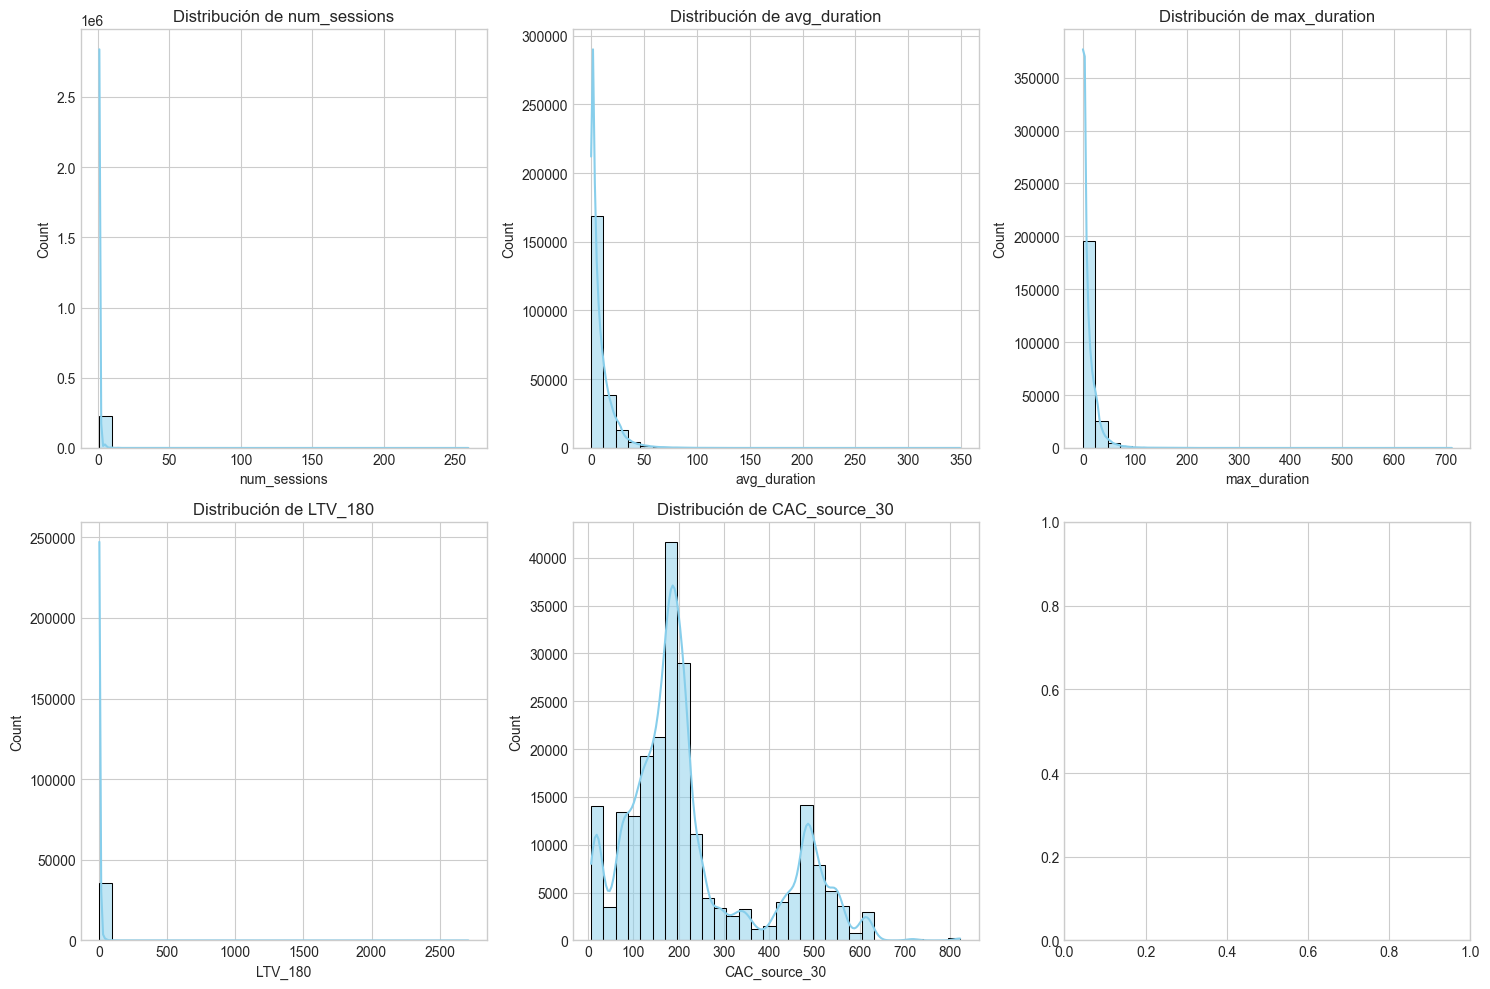

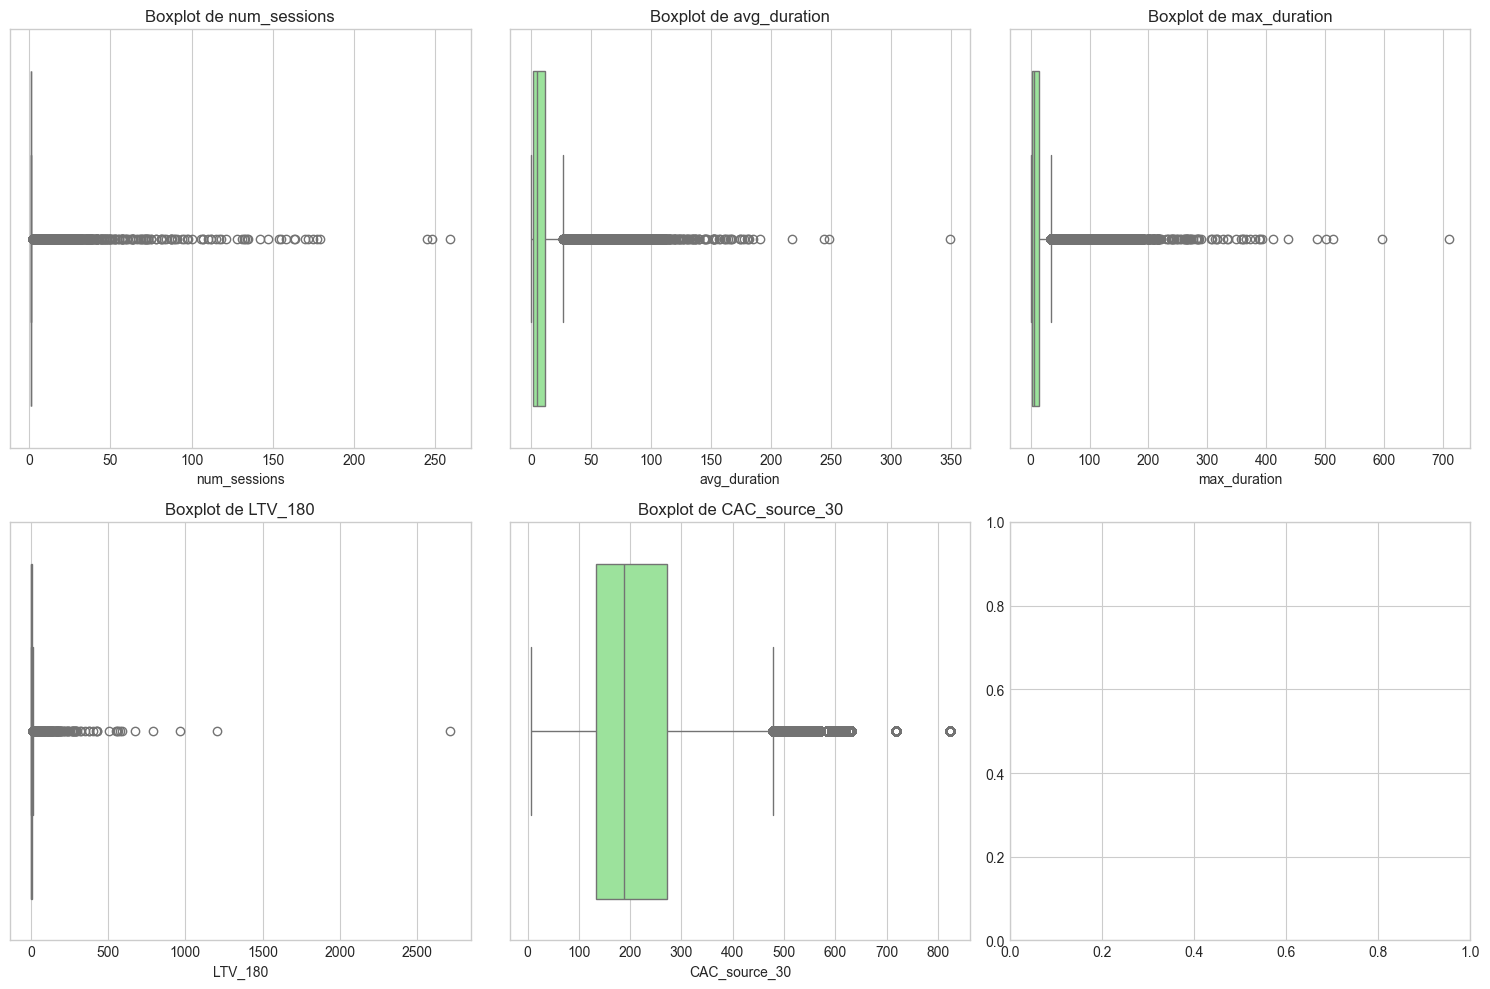

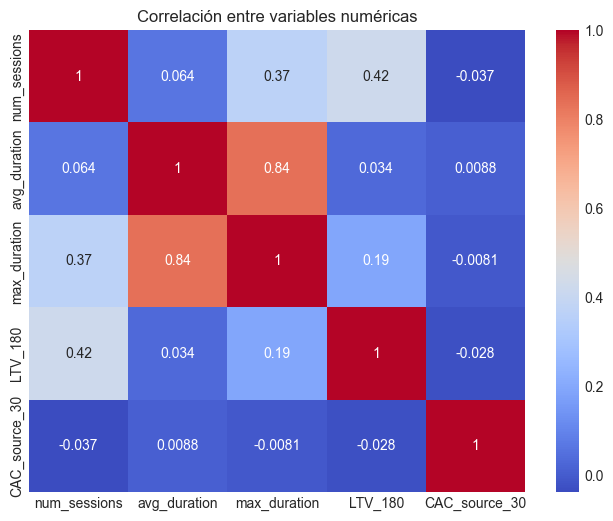

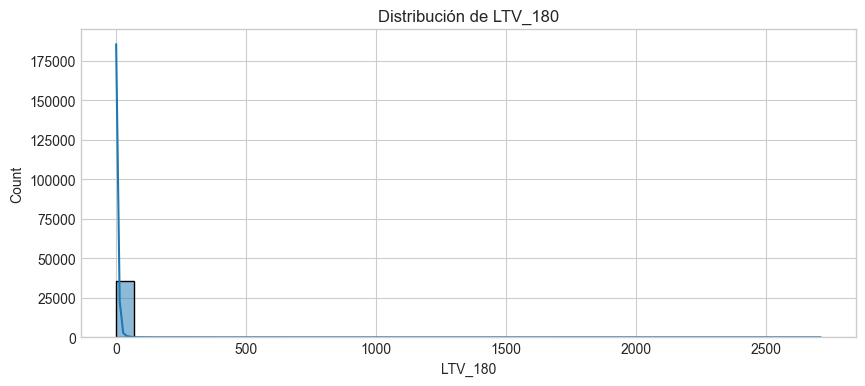

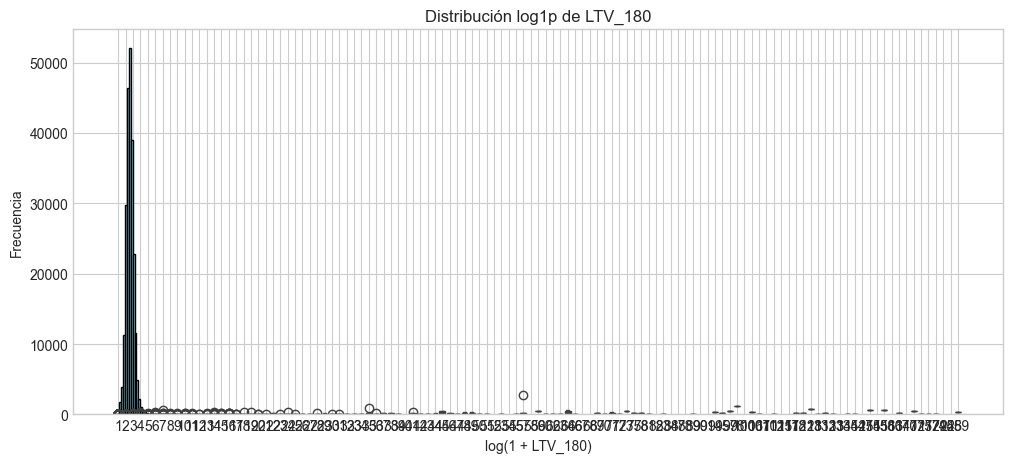

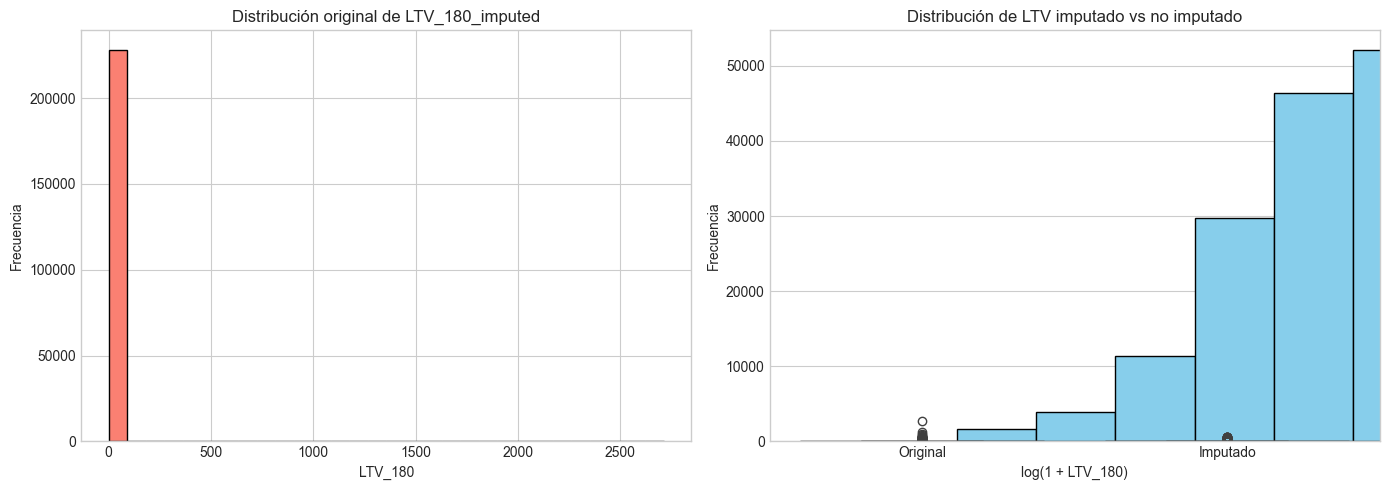

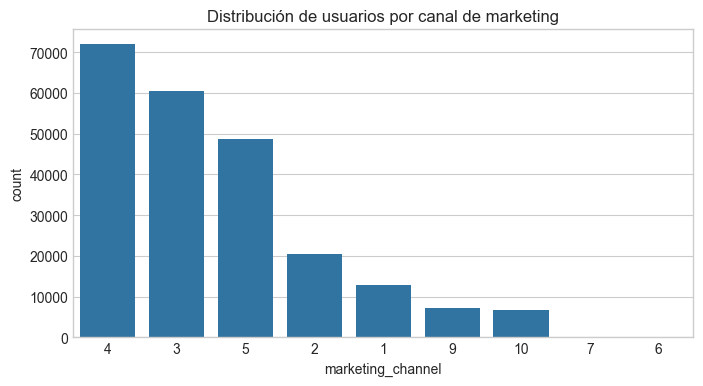

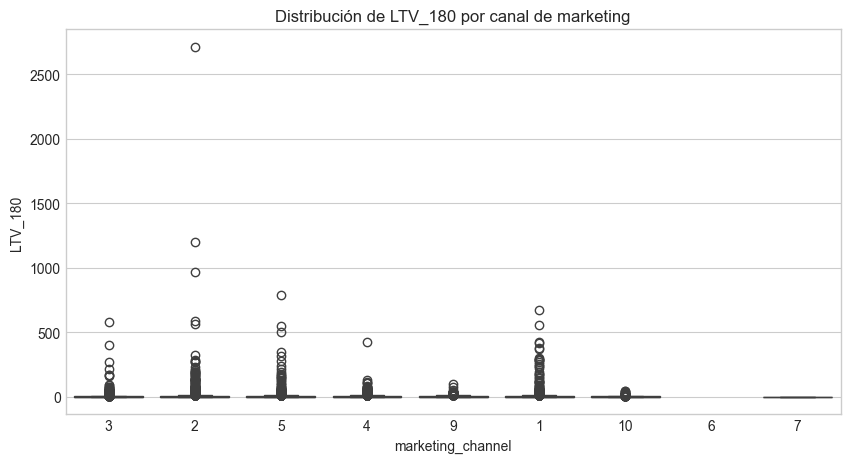

In [26]:
final_figures = {}

# Guardar las distribuciones
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(features[col].dropna(), kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribución de {col}')
plt.tight_layout()
final_figures['distribuciones'] = plt.gcf()

# Guardar los boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=features[col].dropna(), ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Boxplot de {col}')
plt.tight_layout()
final_figures['boxplots'] = plt.gcf()

# Guardar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
final_figures['correlacion'] = plt.gcf()

# Guardar la distribución de LTV_180
plt.figure(figsize=(10, 4))
sns.histplot(features['LTV_180'].dropna(), bins=40, kde=True)
plt.title("Distribución de LTV_180")
final_figures['distribucion_LTV_180'] = plt.gcf()

# Guardar el boxplot de LTV_180 según número de sesiones
plt.figure(figsize=(12, 5))
sns.boxplot(x='num_sessions', y='LTV_180', data=features)
plt.title("LTV_180 según número de sesiones")
final_figures['boxplot_LTV_180_num_sessions'] = plt.gcf()

# Guardar la transformación logarítmica de LTV_180
features['log_LTV_180'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución log1p de LTV_180")
plt.xlabel("log(1 + LTV_180)")
plt.ylabel("Frecuencia")
final_figures['log_LTV_180'] = plt.gcf()

# Guardar comparación entre LTV_180_imputed y log_LTV_180
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Histograma original
axes[0].hist(features['LTV_180_imputed'], bins=30, color='salmon', edgecolor='black')
axes[0].set_title("Distribución original de LTV_180_imputed")
axes[0].set_xlabel("LTV_180")
axes[0].set_ylabel("Frecuencia")
# Histograma transformado
axes[1].hist(features['log_LTV_180'], bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("Distribución transformada (log1p)")
axes[1].set_xlabel("log(1 + LTV_180)")
axes[1].set_ylabel("Frecuencia")
plt.tight_layout()
final_figures['comparacion_LTV_180'] = plt.gcf()

# Guardar la comparación de distribución entre imputados y no imputados
sns.boxplot(x='is_ltv_imputed', y='LTV_180_imputed', data=features)
plt.title("Distribución de LTV imputado vs no imputado")
plt.xticks([0, 1], ['Original', 'Imputado'])
final_figures['distribucion_LTV_imputado'] = plt.gcf()

# Guardar distribución de usuarios por canal de marketing
plt.figure(figsize=(8, 4))
sns.countplot(x='marketing_channel', data=features, order=features['marketing_channel'].value_counts().index)
plt.title("Distribución de usuarios por canal de marketing")
final_figures['usuarios_por_canal_marketing'] = plt.gcf()

# Guardar boxplot de LTV_180 por canal de marketing
plt.figure(figsize=(10, 5))
sns.boxplot(x='marketing_channel', y='LTV_180', data=features)
plt.title("Distribución de LTV_180 por canal de marketing")
final_figures['boxplot_LTV_180_marketing'] = plt.gcf()

# Crear directorios si no existen
figures_dir = "../reports/figures/engineered"
dataset_dir = "../data/engineered"
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)

# Guardar todas las figuras
for name, fig in final_figures.items():
    fig_path = os.path.join(figures_dir, f"{name}.png")
    fig.savefig(fig_path, bbox_inches='tight')
    print(f"Figura guardada: {fig_path}")

# Asegurarse de que final_dataset contenga todas las transformaciones necesarias
final_dataset = features.copy()

# Si has realizado más transformaciones, puedes agregar columnas adicionales antes de guardarlo:
final_dataset['log_LTV_180'] = features['log_LTV_180']
final_dataset['LTV_180_imputed'] = features['LTV_180_imputed']

# Guardar dataset final
dataset_path = os.path.join(dataset_dir, "final_dataset.csv")
final_dataset.to_csv(dataset_path, index=False)
print(f"\nDataset final guardado en: {dataset_path}")